# Bibliotecas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
from scipy.stats import mannwhitneyu

# Dados

In [ ]:
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
order_us = pd.read_csv('/datasets/orders_us.csv')
visits_us = pd.read_csv('/datasets/visits_us.csv')

# Análise Preliminar dos Dados


In [ ]:
hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
# Column Non-Null Count Dtype
--- ------ -------------- -----
0 Hypothesis 9 non-null object
1 Reach 9 non-null int64
2 Impact 9 non-null int64
3 Confidence 9 non-null int64
4 Effort 9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes

In [ ]:
Hypothesis Reach Impact Confidence Effort
0 Add two new channels for attracting traffic. T... 3 10 8 6
1 Launch your own delivery service. This will sh... 2 5 4 10
2 Add product recommendation blocks to the
store... 8 3 7 3
3 Change the category structure. This will incre... 8 3 3 8
4 Change the background color on the main page.
... 3 1 1 1
5 Add a customer review page. This will increase... 3 2 2 3
6 Show banners with current offers and sales on ... 5 3 8 3
7 Add a subscription form to all the main pages.... 10 7 8 5
8 Launch a promotion that gives users discounts ... 1 9 9 5
o

In [ ]:
order_us

In [ ]:
transactionId visitorId date revenue group
0 3667963787 3312258926 2019-08-15 30.4 B
1 2804400009 3642806036 2019-08-15 15.2 B
2 2961555356 4069496402 2019-08-15 10.2 A
3 3797467345 1196621759 2019-08-15 155.1 B
4 2282983706 2322279887 2019-08-15 40.5 B
... ... ... ... ... ...
1192 2662137336 3733762160 2019-08-14 100.8 B
1193 2203539145 370388673 2019-08-14 50.1 A
1194 1807773912 573423106 2019-08-14 165.3 A
1195 1947021204 1614305549 2019-08-14 5.5 A
1196 3936777065 2108080724 2019-08-15 3120.1 B
1197 rows × 5 columns

In [ ]:
print(order_us.isnull().sum())

transactionId 0
visitorId 0
date 0
revenue 0
group 0
dtype: int64

In [ ]:
order_us = order_us.drop_duplicates()

In [ ]:
visits_us

date group visits
0 2019-08-01 A 719
1 2019-08-02 A 619
2 2019-08-03 A 507
3 2019-08-04 A 717
4 2019-08-05 A 756
... ... ... ...
57 2019-08-27 B 720
58 2019-08-28 B 654
59 2019-08-29 B 531
60 2019-08-30 B 490
61 2019-08-31 B 718
62 rows × 3 columns

In [ ]:
print(visits_us.isnull().sum())

In [ ]:
visits_us = visits_us.drop_duplicates()

### Framework RICE

In [ ]:
hypotheses['RICE'] = (hypotheses['Reach']*hypotheses['Impact']*hypotheses['Confidence'])/hypotheses['Effort']
print(hypotheses[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

                                          Hypothesis   RICE
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0
6  Show banners with current offers and sales on ...   40.0
8  Launch a promotion that gives users discounts ...   16.2
3  Change the category structure. This will incre...    9.0
1  Launch your own delivery service. This will sh...    4.0
5  Add a customer review page. This will increase...    4.0
4  Change the background color on the main page. ...    3.0


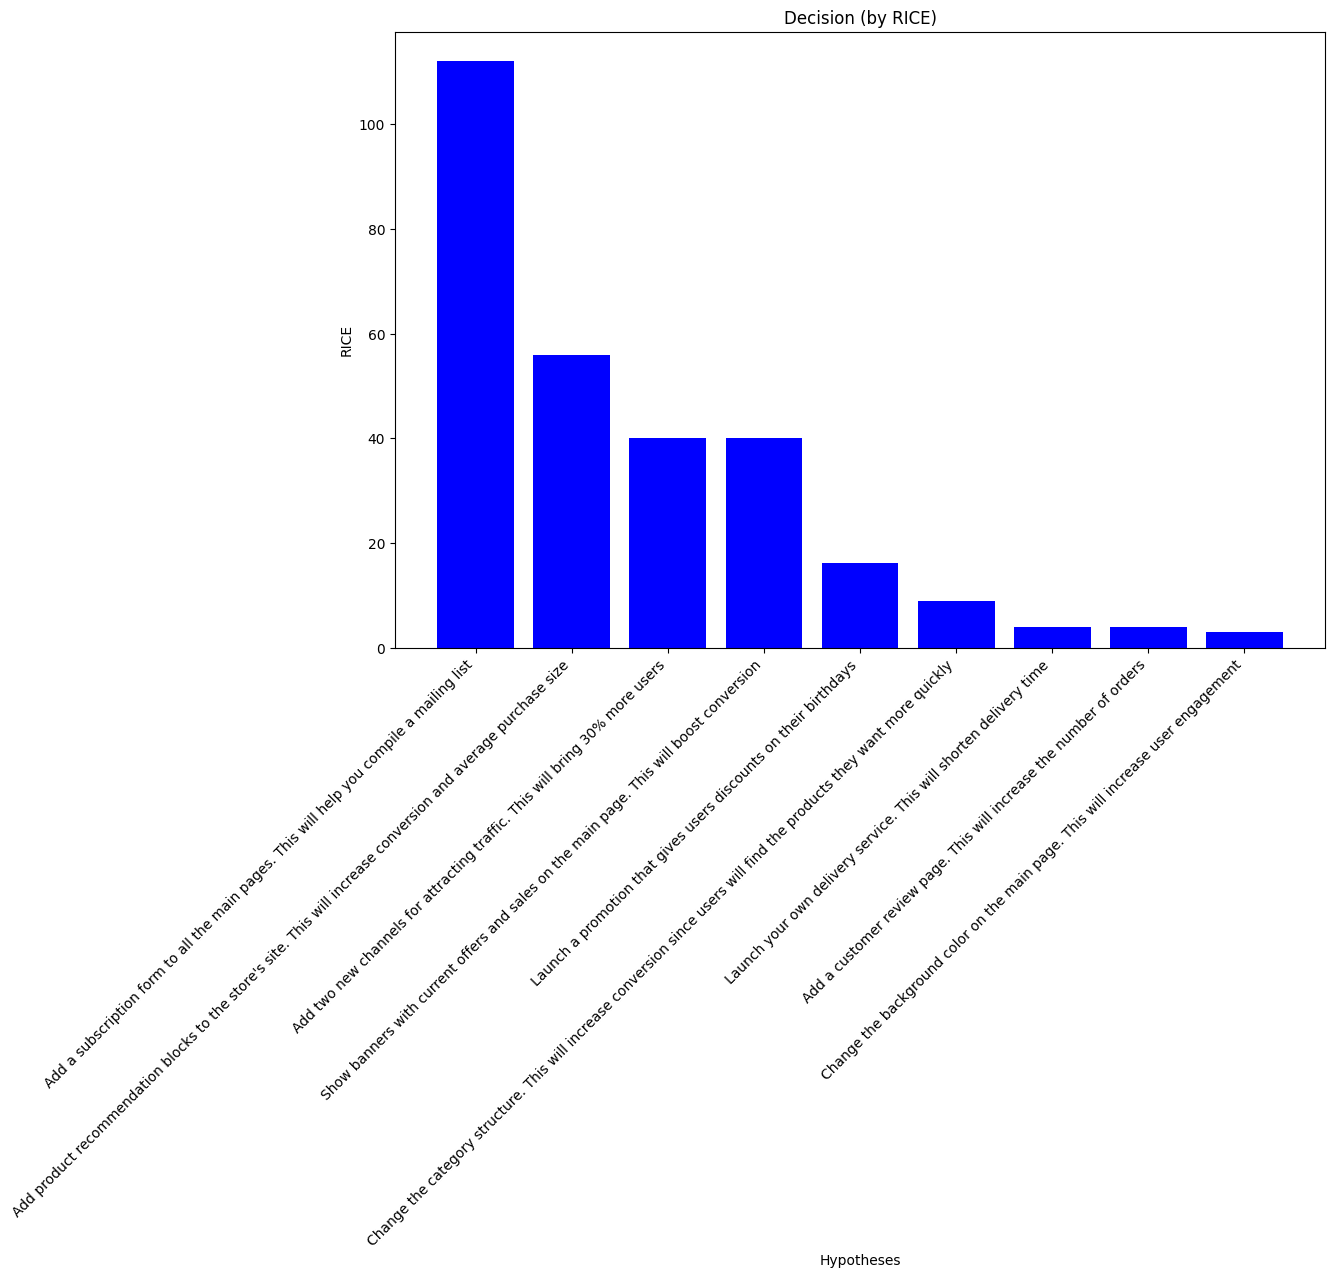

In [ ]:
hypotheses_sorted = hypotheses.sort_values(by='RICE', ascending=False)
plt.figure(figsize=(12,8))
plt.bar(hypotheses_sorted['Hypothesis'], hypotheses_sorted['RICE'], color='blue')
plt.xlabel('Hypotheses')
plt.ylabel('RICE')
plt.title('Decision (by RICE)')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# Na inclusão do alcance (Reach), a hipótese "Add a subscription form to all the main pages" que agora é 112.0, era apenas 11.2 no framework ICE, portanto, o alcance altera as hipóteses para tomada de decisão quanto ao público-alvo.

### Conversão dos Dados

In [ ]:
order_us['date'] = pd.to_datetime(order_us['date'])
visits_us['date'] = pd.to_datetime(visits_us['date'])

### Análise de teste A/B

In [ ]:
# Receita acumulada por grupo

In [ ]:
revenue_cum = (order_us.groupby(['group', 'date'])['revenue'].sum().groupby(level=0).cumsum().reset_index(name='cumulative_revenue'))

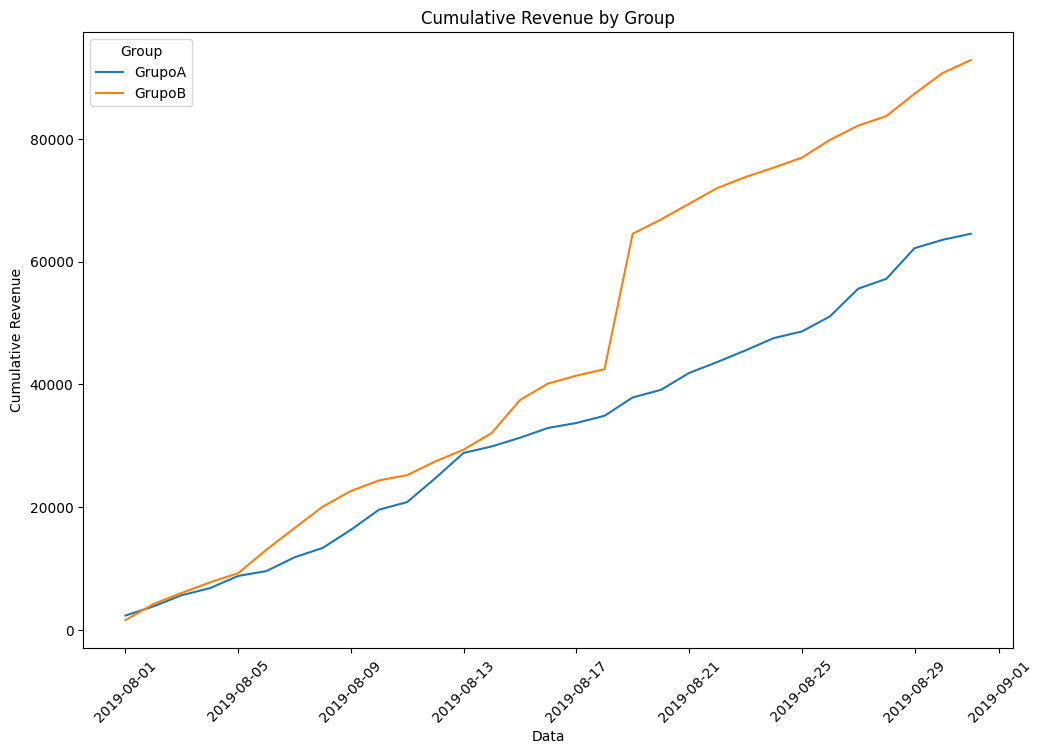

In [ ]:
plt.figure(figsize=(12,8))
for group in revenue_cum['group'].unique():
    group_data = revenue_cum[revenue_cum['group'] == group]
    plt.plot(group_data['date'], group_data['cumulative_revenue'], label=f'Grupo{group}')


plt.xlabel('Data')
plt.ylabel('Cumulative Revenue')
plt.title('Cumulative Revenue by Group')
plt.legend(title='Group')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Tamanho médio acumulado do pedido por grupo

In [ ]:
transactions_cum = (order_us.groupby(['group', 'date'])['transactionId'].count().groupby(level=0).cumsum().reset_index(name='cumulative_transactions'))

In [ ]:
data_cum = pd.merge(revenue_cum, transactions_cum, on=['group', 'date'])
data_cum

,group,date,cumulative_revenue,cumulative_transactions
0,A,2019-08-01,2356.8,24
1,A,2019-08-02,3860.3,44
2,A,2019-08-03,5675.5,68
3,A,2019-08-04,6822.1,84
4,A,2019-08-05,8810.2,109
...,...,...,...,...
57,B,2019-08-27,82161.3,548
58,B,2019-08-28,83719.3,576
59,B,2019-08-29,87343.0,596
60,B,2019-08-30,90736.3,620


In [ ]:
data_cum['average_order_size'] = data_cum['cumulative_revenue'] / data_cum['cumulative_transactions']

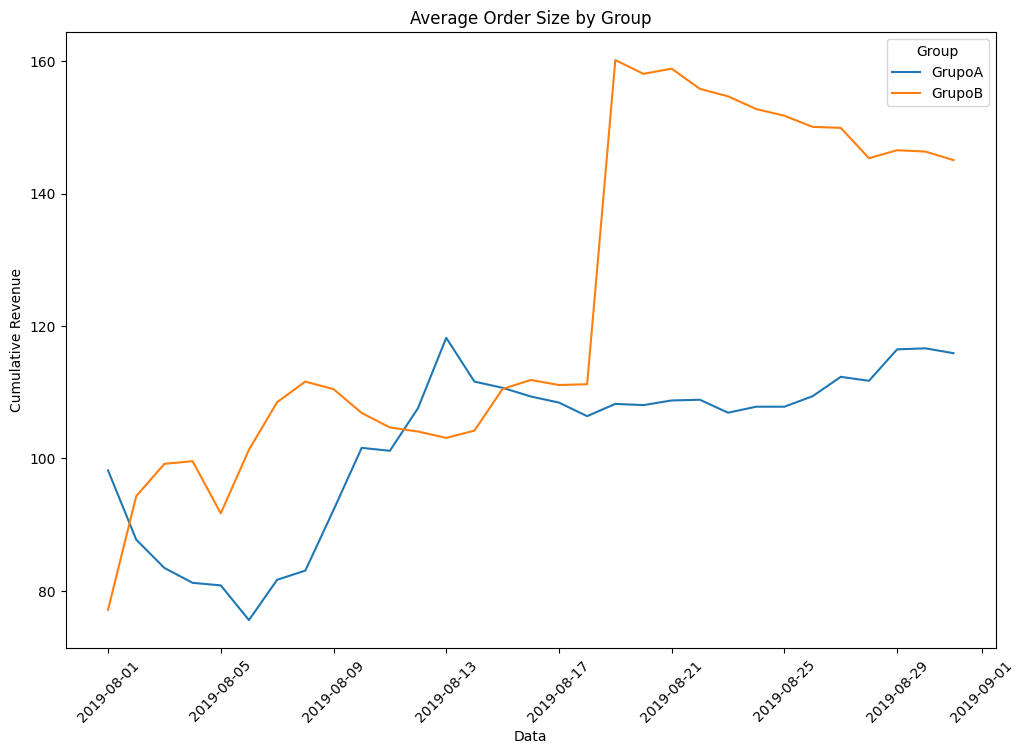

In [ ]:
plt.figure(figsize=(12,8))
for group in data_cum['group'].unique():
    group_data = data_cum[data_cum['group'] == group]
    plt.plot(group_data['date'], group_data['average_order_size'], label=f'Grupo{group}')


plt.xlabel('Data')
plt.ylabel('Cumulative Revenue')
plt.title('Average Order Size by Group')
plt.legend(title='Group')
plt.xticks(rotation=45)
plt.show()

In [ ]:
A média dos pedidos (receita acumulada por transações) é maior para o grupo B ao longo dos dias. Até 13 de agosto o grupo A esboçava uma reação, mas a partir deste período o número médio de pedidos do grupo B cresceu teve um aumento maior, mantendo-se estável o grupo A.

In [ ]:
# Diferença relativa no tamanho médio acumulado do pedido para o grupo B em comparação com o grupo A

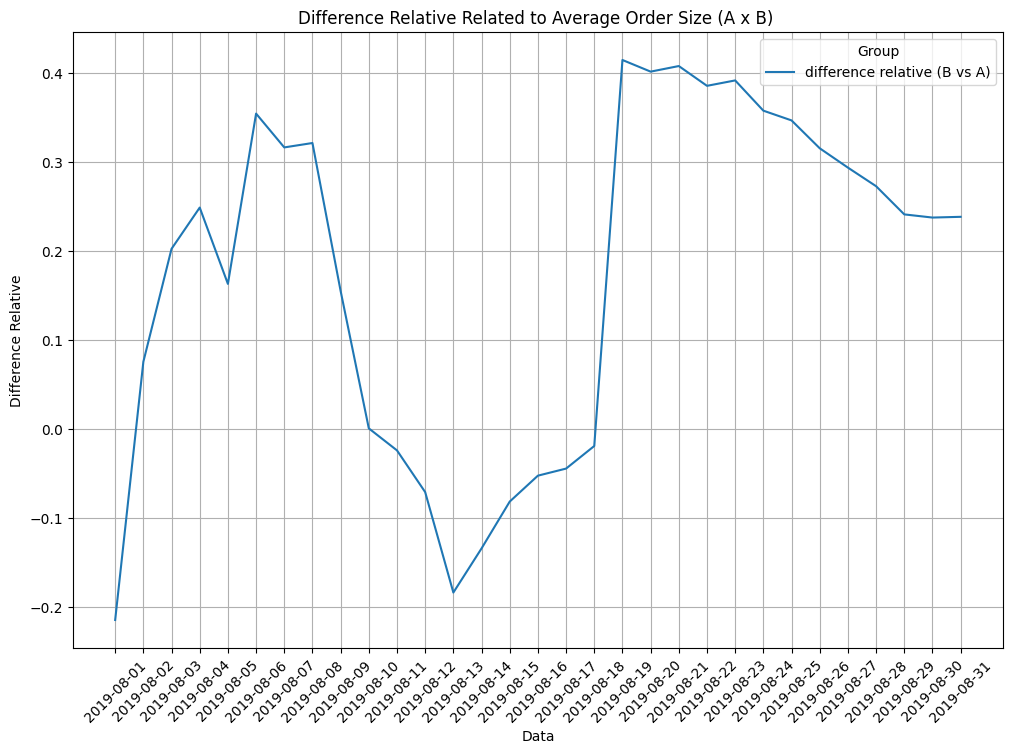

In [ ]:
# Calcular o número de itens por pedido usando 'transactionId'
order_us['num_items'] = order_us.groupby('transactionId')['transactionId'].transform('count')

# Calcular o tamanho médio do pedido por data e grupo
order_us['order_size'] = order_us['revenue'] / order_us['num_items']

# Calcular a média do tamanho do pedido acumulado por data e grupo
cumulative_average_order_size = order_us.groupby(['group', 'date'])['order_size'].mean().groupby(level=0).cumsum().reset_index()

# Adicionar colunas para o gráfico
cumulative_average_order_size_pivot = cumulative_average_order_size.pivot(index='date', columns='group', values='order_size').fillna(0)

# Calcular a diferença relativa no tamanho médio acumulado do pedido para o grupo B em comparação com o grupo A
cumulative_average_order_size_pivot['relative_difference'] = (
    (cumulative_average_order_size_pivot['B'] - cumulative_average_order_size_pivot['A']) / cumulative_average_order_size_pivot['A']
)

plt.figure(figsize=(12,8))
plt.plot(cumulative_average_order_size_pivot.index, cumulative_average_order_size_pivot['relative_difference'],label=f'difference relative (B vs A)')

plt.xlabel('Data')
plt.ylabel('Difference Relative')
plt.title('Difference Relative Related to Average Order Size (A x B) ')
plt.legend(title='Group')
plt.grid()
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Taxa de conversão (número de pedidos por número de visitas) de cada grupo como a proporção de pedidos para o número de visitas para cada dia.

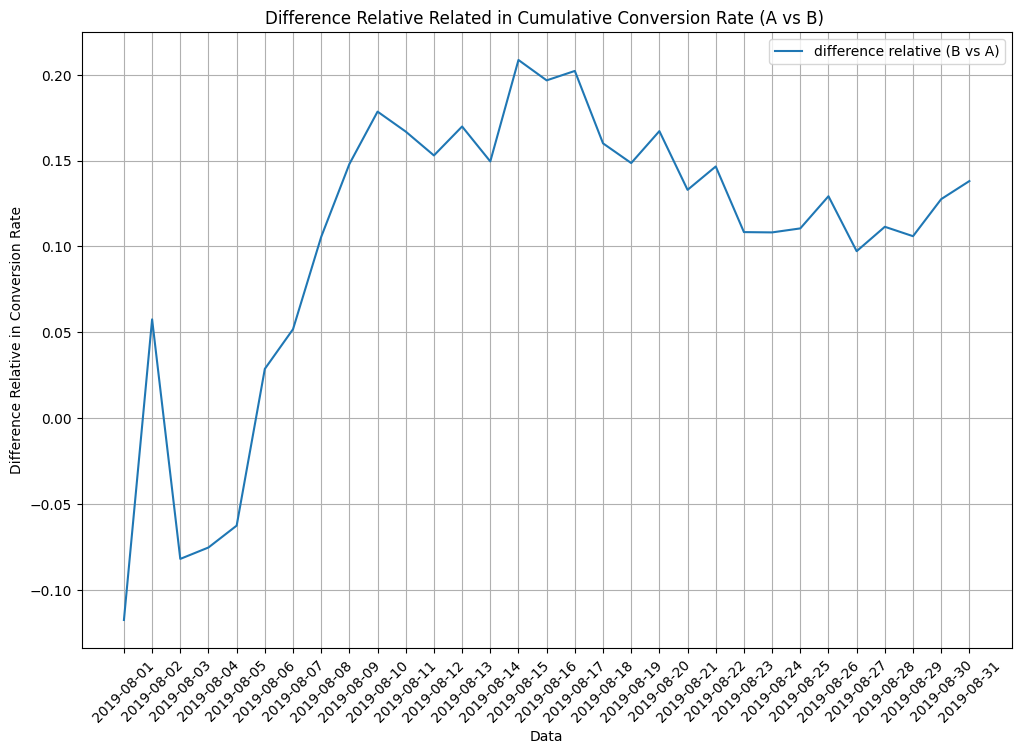

In [ ]:
# Calcular o número de pedidos por data e grupo
orders_by_date_group = order_us.groupby(['date', 'group'])['transactionId'].count().reset_index()
orders_by_date_group.rename(columns={'transactionId': 'order_count'}, inplace=True)

# Agrupar visitas por data e grupo
visits_by_date_group = visits_us.groupby(['date', 'group'])['visits'].sum().reset_index()

# Combinar dados de pedidos e visitas
conversion_data = pd.merge(orders_by_date_group, visits_by_date_group, on=['date', 'group'])

# Calcular a conversão cumulativa para cada grupo
conversion_data['cumulative_orders'] = conversion_data.groupby('group')['order_count'].cumsum()
conversion_data['cumulative_visits'] = conversion_data.groupby('group')['visits'].cumsum()
conversion_data['cumulative_conversion'] = conversion_data['cumulative_orders'] / conversion_data['cumulative_visits']

# Separar os dados por grupo
group_a = conversion_data[conversion_data['group'] == 'A']
group_b = conversion_data[conversion_data['group'] == 'B']

# Calcular a diferença relativa na conversão cumulativa
relative_difference = pd.DataFrame({
    'date': group_a['date'],
    'relative_difference': (group_b['cumulative_conversion'].values - group_a['cumulative_conversion'].values) / group_a['cumulative_conversion'].values
})

plt.figure(figsize=(12,8))
plt.plot(relative_difference['date'], relative_difference['relative_difference'], label=f'difference relative (B vs A)')

plt.xlabel('Data')
plt.ylabel('Difference Relative in Conversion Rate')
plt.title('Difference Relative Related in Cumulative Conversion Rate (A vs B) ')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Cálculo dos percentis 95 e 99 para o número de pedidos por usuário.

In [ ]:
orders_per_user = order_us.groupby('visitorId').size().reset_index(name='order_num')

In [ ]:
print(np.percentile(orders_per_user['visitorId'], [95, 99]))

[4.03708104e+09 4.24195110e+09]


In [ ]:
percentil_95 = orders_per_user['order_num'].quantile(0.95)
percentil_99 = orders_per_user['order_num'].quantile(0.99)

In [ ]:
anomalies = orders_per_user[orders_per_user['order_num'] > percentil_99]
anomalies

,visitorId,order_num
44,199603092,5
55,237748145,5
299,1230306981,5
487,2038680547,8
569,2378935119,9
591,2458001652,11
744,3062433592,5
897,3717692402,5
917,3803269165,5
1023,4256040402,11


In [ ]:
Há 10 usuários em que o número de pedidos excederam o percentil 99

In [ ]:
# Significância estatística da diferença na conversão entre os grupos usando os dados brutos

In [ ]:
orders_visitors_A = order_us[order_us['group'] == 'A'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
orders_visitors_A.columns = ['visitorsId', 'orders']

orders_visitors_B = order_us[order_us['group'] == 'B'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
orders_visitors_B.columns = ['visitorsId', 'orders']

# se algum visitante entrou, mas não fez pedido:

sampleA = pd.concat(
    [orders_visitors_A['orders'],
     pd.Series(0, index=np.arange(visits_us[visits_us['group'] == 'A']['visits'].sum()-len(orders_visitors_A['orders'])), name='orders')], axis=0)

sampleB = pd.concat(
    [orders_visitors_B['orders'],
     pd.Series(0, index=np.arange(visits_us[visits_us['group'] == 'B']['visits'].sum()-len(orders_visitors_A['orders'])), name='orders')], axis=0)

p_value = mannwhitneyu(sampleA, sampleB)[1]

# calculo da diferença

difference = sampleB.mean() / sampleA.mean() - 1

print(f'p-value: {p_value:.3f}')
print(f'diferença percentual média entre os grupos: {difference:.3f}')


p-value: 0.020
diferença percentual média entre os grupos: 0.133


In [ ]:
# identificar as anomalias
anomalies = orders_per_user[orders_per_user['order_num'] > percentil_99].index

# remover as anomalias
filtered_orders = order_us[~order_us['visitorId'].isin(anomalies)]

# calcular o tamanho médio do pedido para cada grupo
filtered_orders['order_size'] = filtered_orders['revenue'] / filtered_orders.groupby('transactionId')['transactionId'].transform('count')
group_a_orders = filtered_orders[filtered_orders['group'] == 'A']['order_size']
group_b_orders = filtered_orders[filtered_orders['group'] == 'B']['order_size']

# realizar o teste de MannWhitneyu
p_value = mannwhitneyu(group_a_orders, group_a_orders)[1]

# calcular a diferença percentual no tamanho médio entre os grupos
mean_group_a = group_a_orders.mean()
mean_group_b = group_b_orders.mean()
percentual_difference = ((mean_group_b - mean_group_a) / mean_group_a) * 100

# print dos resultados
print(f'p_value: {p_value:.3f}')
print(f'diferença percentual: {percentual_difference:.2f}%')

# conclusão da análise
if p_value < 0.05:
    print('Há uma diferença significativa no tamanho médio do pedido entre os grupos')
else:
    print('NÃO há uma diferença significativa no tamanho médio do pedido entre os grupos')

p_value: 1.000
diferença percentual: 25.17%
NÃO há uma diferença significativa no tamanho médio do pedido entre os grupos


In [ ]:
Com um valor p_value > 0.05, não há evidências suficientes para afirmar que há uma diferença significativa no tamanho médio do pedido entre os grupos.

In [ ]:
Conclusão:
    o p-value menor que 0.05 indica que podemos rejeitar a hipótese nula de que não há diferença entre os grupos A e B no cálculo da conversão.
    A magnitude da diferença percentual do grupo B (>10%) indica ser uma estratégia importante, pois a perfomance é melhor.
    Portanto, a estratégia do grupo B parece trazer maiores resultados. No entanto, não há evidências suficientes de que o tamanho médio dos
    pedidos entre os grupos sejam muito diferentes, uma vez que o p_value para este caso foi igual a 1.000.